In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls ('/content/drive/MyDrive/kilterboard_data/')

/bin/bash: -c: line 1: syntax error near unexpected token `'/content/drive/MyDrive/kilterboard_data/''
/bin/bash: -c: line 1: `ls ('/content/drive/MyDrive/kilterboard_data/')'


In [3]:
climbs = pd.read_csv('/content/drive/MyDrive/kilterboard_data/climbs.csv')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import json
from collections import Counter

# Helper functions

def difficulty_to_vgrade(difficulty):
    """Convert Kilter Board difficulty_average to V-grade with a refined scale"""
    if difficulty is None or pd.isna(difficulty):
        return "N/A"

    # Detailed conversion
    if difficulty < 8:
        return "VB"
    elif difficulty < 10:
        return "V0"
    elif difficulty < 12:
        return "V1"
    elif difficulty < 14:
        return "V2"
    elif difficulty < 16:
        return "V3"
    elif difficulty < 18:
        return "V4"
    elif difficulty < 20:
        return "V5"
    elif difficulty < 22:
        return "V6"
    elif difficulty < 24:
        return "V7"
    elif difficulty < 26:
        return "V8"
    elif difficulty < 28:
        return "V9"
    elif difficulty < 30:
        return "V10"
    elif difficulty < 32:
        return "V11"
    elif difficulty < 34:
        return "V12"
    elif difficulty < 36:
        return "V13"
    elif difficulty < 38:
        return "V14"
    elif difficulty < 40:
        return "V15"
    else:
        return "V16+"

def parse_climb_stats(stats_str):
    """Parse the climb_stats string into a list of dictionaries"""
    if not isinstance(stats_str, str):
        return []

    # Clean the string if it's wrapped in quotes and brackets
    if stats_str.startswith('["[') and stats_str.endswith(']"]'):
        stats_str = stats_str[3:-3]  # Remove the ["[ and ]"]

    try:
        # Try parsing as a list of dictionaries
        return ast.literal_eval(stats_str)
    except (SyntaxError, ValueError):
        print(f"Error parsing: {stats_str[:100]}...")
        return []

def find_most_popular_setup(climb_stats):
    """Find the angle with the most ascents"""
    stats_list = parse_climb_stats(climb_stats)

    most_ascents = 0
    popular_setup = None

    for stats in stats_list:
        ascents = stats.get('ascensionist_count', 0)
        if ascents > most_ascents:
            most_ascents = ascents
            popular_setup = stats

    return popular_setup

def count_holds(placements_str):
    """Count the number of holds used in a problem from the placements field"""
    if not placements_str or pd.isna(placements_str):
        return 0

    try:
        # Try to parse the placements string
        placements = ast.literal_eval(placements_str)
        return len(placements)
    except (SyntaxError, ValueError):
        print(f"Error parsing placements: {placements_str[:100]}...")
        return 0

def load_data(data_source):
    """Load data from a file path or return the DataFrame if already loaded"""
    if isinstance(data_source, pd.DataFrame):
        return data_source.copy()
    elif isinstance(data_source, str):
        if data_source.endswith('.csv'):
            return pd.read_csv(data_source)
        elif data_source.endswith('.json'):
            with open(data_source, 'r') as f:
                data = json.load(f)
            return pd.DataFrame(data)
        else:
            print("Unsupported file format. Please use CSV or JSON.")
            return None
    else:
        print("Unsupported data type. Please provide a file path or pandas DataFrame.")
        return None

# Main functions

def create_data_profile(data_source):
    """Create a comprehensive data profile from the Kilterboard dataset"""
    df = load_data(data_source)
    if df is None:
        return None

    print(f"Dataset contains {len(df)} boulder problems")

    # 1. Count boulders per grade across all angles
    all_grades = []

    # Process each climb and its various setups
    for _, row in df.iterrows():
        stats_list = parse_climb_stats(row.get('climb_stats', []))

        for stats in stats_list:
            difficulty = stats.get('difficulty_average')
            if difficulty is not None:
                vgrade = difficulty_to_vgrade(difficulty)
                all_grades.append(vgrade)

    all_grades_count = Counter(all_grades)

    # Print results for all angles
    print("\n1. Boulder Count Per Grade (All Angles):")
    for grade in sorted(all_grades_count.keys(), key=lambda g: (g[0], int(g[1:]) if g[1:].isdigit() else 0)):
        print(f"  {grade}: {all_grades_count[grade]} problems")

    # 2. Count boulders per grade at most popular angle only
    popular_grades = []

    for _, row in df.iterrows():
        popular_setup = find_most_popular_setup(row.get('climb_stats', []))

        if popular_setup:
            difficulty = popular_setup.get('difficulty_average')
            if difficulty is not None:
                vgrade = difficulty_to_vgrade(difficulty)
                popular_grades.append(vgrade)

    popular_grades_count = Counter(popular_grades)

    # Print results for most popular angles
    print("\n2. Boulder Count Per Grade (Most Popular Angle Only):")
    for grade in sorted(popular_grades_count.keys(), key=lambda g: (g[0], int(g[1:]) if g[1:].isdigit() else 0)):
        print(f"  {grade}: {popular_grades_count[grade]} problems")

    # 3. Average number of holds used
    # Check if 'placements' column exists
    if 'placements' in df.columns:
        # Calculate number of holds for each problem
        df['hold_count'] = df['placements'].apply(count_holds)
        avg_holds = df['hold_count'].mean()

        print(f"\n3. Average Number of Holds Used: {avg_holds:.2f}")

        # Print distribution of hold counts
        print("\nHold Count Distribution:")
        hold_count_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
        hold_count_hist = pd.cut(df['hold_count'], bins=hold_count_bins).value_counts().sort_index()
        for bin_range, count in hold_count_hist.items():
            print(f"  {bin_range}: {count} problems")
    else:
        print("\n3. Cannot calculate average number of holds - 'placements' column not found")
        avg_holds = None

    # 4. Bonus: Distribution of angles used
    angles = []

    for _, row in df.iterrows():
        stats_list = parse_climb_stats(row.get('climb_stats', []))

        for stats in stats_list:
            angle = stats.get('angle')
            if angle is not None:
                angles.append(angle)

    angle_count = Counter(angles)

    # Print angle distribution
    print("\n4. Board Angle Distribution:")
    for angle in sorted(angle_count.keys()):
        print(f"  {angle}°: {angle_count[angle]} setups")

    # Return compiled statistics for further use if needed
    return {
        'all_grades_count': all_grades_count,
        'popular_grades_count': popular_grades_count,
        'angles_count': angle_count,
        'avg_holds': avg_holds,
        'dataframe': df  # Return the dataframe with hold_count added if applicable
    }

def remove_hold_count_outliers(data_source, upper_percentile=95, output_file=None):
    """
    Create a new dataframe without outliers in the upper range of hold counts

    Parameters:
    -----------
    data_source : pandas.DataFrame or str
        Either a pandas DataFrame containing the climb data or a file path (CSV or JSON)
    upper_percentile : float, optional
        Percentile threshold for upper outliers (default: 95)
    output_file : str, optional
        Path to save the distribution plot (if None, plot will be displayed)

    Returns:
    --------
    tuple
        (cleaned_df, dict with statistics)
    """
    df = load_data(data_source)
    if df is None:
        return None, None

    # Check if 'placements' column exists
    if 'placements' not in df.columns:
        print("Cannot analyze hold counts - 'placements' column not found in the data")
        return None, None

    # Calculate number of holds for each problem if not already done
    if 'hold_count' not in df.columns:
        df['hold_count'] = df['placements'].apply(count_holds)

    # Remove any rows with 0 holds (likely parsing errors)
    df = df[df['hold_count'] > 0]

    # Get original statistics
    original_count = len(df)
    original_min = df['hold_count'].min()
    original_max = df['hold_count'].max()
    original_mean = df['hold_count'].mean()
    original_median = df['hold_count'].median()
    original_std = df['hold_count'].std()

    # Calculate the upper threshold
    upper_threshold = df['hold_count'].quantile(upper_percentile/100)

    # Create filtered dataframe
    cleaned_df = df[df['hold_count'] <= upper_threshold]

    # Get new statistics
    cleaned_count = len(cleaned_df)
    cleaned_min = cleaned_df['hold_count'].min()
    cleaned_max = cleaned_df['hold_count'].max()
    cleaned_mean = cleaned_df['hold_count'].mean()
    cleaned_median = cleaned_df['hold_count'].median()
    cleaned_std = cleaned_df['hold_count'].std()

    # Print summary comparison
    print("Hold Count Statistics Comparison:")
    print("--------------------------------")
    print(f"{'Metric':<15} {'Original':<15} {'Cleaned':<15}")
    print(f"{'Count':<15} {original_count:<15} {cleaned_count:<15}")
    print(f"{'Min':<15} {original_min:<15} {cleaned_min:<15}")
    print(f"{'Max':<15} {original_max:<15} {cleaned_max:<15}")
    print(f"{'Mean':<15} {original_mean:<15.2f} {cleaned_mean:<15.2f}")
    print(f"{'Median':<15} {original_median:<15} {cleaned_median:<15}")
    print(f"{'Std Dev':<15} {original_std:<15.2f} {cleaned_std:<15.2f}")
    print(f"{'Upper Threshold':<15} {'-':<15} {upper_threshold:<15}")
    print(f"{'Removed':<15} {'-':<15} {original_count - cleaned_count:<15} ({(original_count - cleaned_count)/original_count*100:.1f}%)")

    # Generate comparison histograms if desired
    if output_file:
        plt.figure(figsize=(14, 7))

        # Plot original data
        plt.subplot(1, 2, 1)
        plt.hist(df['hold_count'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
        plt.axvline(x=upper_threshold, color='red', linestyle='--', linewidth=2)
        plt.xlabel('Number of Holds', fontsize=12)
        plt.ylabel('Number of Problems', fontsize=12)
        plt.title('Original Distribution', fontsize=14)
        plt.grid(axis='y', alpha=0.3)

        # Plot cleaned data
        plt.subplot(1, 2, 2)
        plt.hist(cleaned_df['hold_count'], bins=30, alpha=0.7, color='green', edgecolor='black')
        plt.axvline(x=upper_threshold, color='red', linestyle='--', linewidth=2)
        plt.xlabel('Number of Holds', fontsize=12)
        plt.ylabel('Number of Problems', fontsize=12)
        plt.title('Cleaned Distribution (Outliers Removed)', fontsize=14)
        plt.grid(axis='y', alpha=0.3)

        plt.suptitle(f'Distribution of Hold Counts (Upper {upper_percentile}% Outliers Removed)', fontsize=16)
        plt.tight_layout()
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Comparison plot saved to {output_file}")
        plt.close()

    # Create distribution table for cleaned data
    hold_count_counter = Counter(cleaned_df['hold_count'])
    sorted_counts = sorted(hold_count_counter.items())

    print("\nCleaned Hold Count Distribution:")
    print("----------------------")
    print("Holds | Count | Percentage")
    print("----------------------")
    total_problems = len(cleaned_df)

    for holds, count in sorted_counts:
        if count > 5:  # Only show if there are more than 5 examples
            percentage = (count / total_problems) * 100
            print(f"{holds:5d} | {count:5d} | {percentage:6.2f}%")

    # Return the cleaned dataframe and statistics
    stats = {
        'original': {
            'count': original_count,
            'min': original_min,
            'max': original_max,
            'mean': original_mean,
            'median': original_median,
            'std': original_std
        },
        'cleaned': {
            'count': cleaned_count,
            'min': cleaned_min,
            'max': cleaned_max,
            'mean': cleaned_mean,
            'median': cleaned_median,
            'std': cleaned_std,
            'upper_threshold': upper_threshold,
            'hold_count_distribution': dict(hold_count_counter)
        }
    }

    return cleaned_df, stats

def analyze_and_clean_data(data_source, upper_percentile=95, save_cleaned=False, output_folder=None):
    """
    Comprehensive function that creates a data profile and removes outliers in one go

    Parameters:
    -----------
    data_source : pandas.DataFrame or str
        Either a pandas DataFrame or a file path to the data
    upper_percentile : float, optional
        Percentile threshold for upper outliers (default: 95)
    save_cleaned : bool, optional
        Whether to save the cleaned data as a CSV file (default: False)
    output_folder : str, optional
        Folder where to save the cleaned data and plots (if None, current directory)

    Returns:
    --------
    tuple
        (cleaned_df, data_profile, stats)
    """
    # Create the data profile first
    profile = create_data_profile(data_source)

    if profile is None:
        return None, None, None

    df = profile['dataframe']

    # Determine output path
    if output_folder is None:
        output_folder = ""
    else:
        # Ensure path ends with /
        if not output_folder.endswith('/'):
            output_folder += '/'

    # Generate plot filename
    plot_filename = f"{output_folder}hold_count_comparison.png"

    # Remove outliers
    cleaned_df, stats = remove_hold_count_outliers(df, upper_percentile, output_file=plot_filename)

    if save_cleaned and cleaned_df is not None:
        # Generate output filename
        if isinstance(data_source, str) and (data_source.endswith('.csv') or data_source.endswith('.json')):
            base_name = data_source.split('/')[-1].split('.')[0]
            output_file = f"{output_folder}cleaned_{base_name}.csv"
        else:
            output_file = f"{output_folder}cleaned_kilterboard_data.csv"

        # Save to CSV
        cleaned_df.to_csv(output_file, index=False)
        print(f"Cleaned data saved to {output_file}")

    # Generate grade distribution plot from profile
    if profile:
        grades = list(profile['popular_grades_count'].keys())
        counts = list(profile['popular_grades_count'].values())

        plt.figure(figsize=(12, 6))
        plt.bar(grades, counts)
        plt.xlabel('V-Grade', fontsize=12)
        plt.ylabel('Number of Problems', fontsize=12)
        plt.title('Distribution of Boulder Problems by V-Grade (Most Popular Angle)', fontsize=14)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"{output_folder}grade_distribution.png", dpi=300)
        print(f"Grade distribution plot saved to {output_folder}grade_distribution.png")
        plt.close()

    return cleaned_df, profile, stats

# Example usage
"""if __name__ == "__main__":
    # Complete analysis and cleaning
    filepath = '/content/drive/MyDrive/kilterboard_data/climbs.csv'
    cleaned_df, profile, stats = analyze_and_clean_data(
        filepath,
        upper_percentile=90,
        save_cleaned=False,
        output_folder='/content/drive/MyDrive/kilterboard_data/'
    )"""

'if __name__ == "__main__":\n    # Complete analysis and cleaning\n    filepath = \'/content/drive/MyDrive/kilterboard_data/climbs.csv\'\n    cleaned_df, profile, stats = analyze_and_clean_data(\n        filepath,\n        upper_percentile=90,\n        save_cleaned=False,\n        output_folder=\'/content/drive/MyDrive/kilterboard_data/\'\n    )'

In [24]:
def compare_climbing_dataframes(df1, df2, df1_name="Dataset 1", df2_name="Dataset 2", plot=True):
    """
    Compare two climbing route DataFrames and print a summary of key metrics.

    Parameters:
    -----------
    df1 : pandas.DataFrame
        First DataFrame with climb_stats column requiring parsing
    df2 : pandas.DataFrame
        Second DataFrame with cleaner structure including ascents and hold_count columns
    df1_name : str, optional
        Name for the first dataset (default: "Dataset 1")
    df2_name : str, optional
        Name for the second dataset (default: "Dataset 2")
    plot : bool, optional
        Whether to create comparison visualizations (default: True)

    Returns:
    --------
    dict
        Dictionary containing the comparison metrics
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import defaultdict

    # Initialize results dictionary
    results = {
        'datapoints': {df1_name: len(df1), df2_name: len(df2)},
        'holds': defaultdict(dict),
        'ascents': defaultdict(dict)
    }

    # Compare hold counts
    try:
        # For the first dataframe, calculate hold_count from placements
        if 'placements' in df1.columns:
            df1_temp = df1.copy()
            df1_temp['hold_count'] = df1_temp['placements'].apply(count_holds)
            df1_holds = df1_temp['hold_count'].dropna()

            # Calculate statistics
            results['holds'][df1_name]['mean'] = df1_holds.mean()
            results['holds'][df1_name]['min'] = df1_holds.min()
            results['holds'][df1_name]['max'] = df1_holds.max()
            results['holds'][df1_name]['std'] = df1_holds.std()
        else:
            print(f"Warning: Cannot calculate hold statistics for {df1_name} - 'placements' column not found")

        # For the second dataframe, use the existing hold_count column
        if 'hold_count' in df2.columns:
            df2_holds = df2['hold_count'].dropna()

            # Calculate statistics
            results['holds'][df2_name]['mean'] = df2_holds.mean()
            results['holds'][df2_name]['min'] = df2_holds.min()
            results['holds'][df2_name]['max'] = df2_holds.max()
            results['holds'][df2_name]['std'] = df2_holds.std()
        else:
            print(f"Warning: 'hold_count' column not found in {df2_name}")
    except Exception as e:
        print(f"Error processing hold counts: {e}")

    # Compare ascent counts
    try:
        # For the first dataframe, parse climb_stats to get ascensionist_count
        df1_ascents = []

        for _, row in df1.iterrows():
            if 'climb_stats' in row:
                stats_list = parse_climb_stats(row['climb_stats'])

                # Each angle setting is treated as a separate boulder
                for stats in stats_list:
                    if 'ascensionist_count' in stats:
                        df1_ascents.append(stats['ascensionist_count'])

        if df1_ascents:
            # Convert to numpy array for easier statistics
            df1_ascents_array = np.array(df1_ascents)

            # Calculate statistics
            results['ascents'][df1_name]['mean'] = np.mean(df1_ascents_array)
            results['ascents'][df1_name]['min'] = np.min(df1_ascents_array)
            results['ascents'][df1_name]['max'] = np.max(df1_ascents_array)
            results['ascents'][df1_name]['std'] = np.std(df1_ascents_array)

        # For the second dataframe, use the ascents column directly
        if 'ascents' in df2.columns:
            df2_ascents_array = df2['ascents'].dropna().values

            if len(df2_ascents_array) > 0:
                # Calculate statistics
                results['ascents'][df2_name]['mean'] = np.mean(df2_ascents_array)
                results['ascents'][df2_name]['min'] = np.min(df2_ascents_array)
                results['ascents'][df2_name]['max'] = np.max(df2_ascents_array)
                results['ascents'][df2_name]['std'] = np.std(df2_ascents_array)
        else:
            print(f"Warning: 'ascents' column not found in {df2_name}")
    except Exception as e:
        print(f"Error processing ascent counts: {e}")
        import traceback
        traceback.print_exc()

    # Print summary table
    print(f"\nComparison: {df1_name} vs {df2_name}")
    print("=" * 90)
    print(f"{'Metric':<15} {'Dataset':<12} {'Count':<10} {'Mean':<10} {'Min':<10} {'Max':<10} {'Std Dev':<10}")
    print("-" * 90)

    # Datapoints
    print(f"{'Datapoints':<15} {df1_name:<12} {len(df1):<10} {'-':<10} {'-':<10} {'-':<10} {'-':<10}")
    print(f"{'Datapoints':<15} {df2_name:<12} {len(df2):<10} {'-':<10} {'-':<10} {'-':<10} {'-':<10}")

    # Hold counts
    if df1_name in results['holds']:
        print(f"{'Holds':<15} {df1_name:<12} {'-':<10} "
              f"{results['holds'][df1_name]['mean']:.2f} {' ' * 5} "
              f"{results['holds'][df1_name]['min']:.0f} {' ' * 7} "
              f"{results['holds'][df1_name]['max']:.0f} {' ' * 7} "
              f"{results['holds'][df1_name]['std']:.2f}")

    if df2_name in results['holds']:
        print(f"{'Holds':<15} {df2_name:<12} {'-':<10} "
              f"{results['holds'][df2_name]['mean']:.2f} {' ' * 5} "
              f"{results['holds'][df2_name]['min']:.0f} {' ' * 7} "
              f"{results['holds'][df2_name]['max']:.0f} {' ' * 7} "
              f"{results['holds'][df2_name]['std']:.2f}")

    # Ascent counts
    if df1_name in results['ascents']:
        print(f"{'Ascents':<15} {df1_name:<12} {'-':<10} "
              f"{results['ascents'][df1_name]['mean']:.2f} {' ' * 5} "
              f"{results['ascents'][df1_name]['min']:.0f} {' ' * 7} "
              f"{results['ascents'][df1_name]['max']:.0f} {' ' * 7} "
              f"{results['ascents'][df1_name]['std']:.2f}")

    if df2_name in results['ascents']:
        print(f"{'Ascents':<15} {df2_name:<12} {'-':<10} "
              f"{results['ascents'][df2_name]['mean']:.2f} {' ' * 5} "
              f"{results['ascents'][df2_name]['min']:.0f} {' ' * 7} "
              f"{results['ascents'][df2_name]['max']:.0f} {' ' * 7} "
              f"{results['ascents'][df2_name]['std']:.2f}")

    # Create visualizations
    if plot:
        try:
            # Set a consistent style
            plt.style.use('seaborn-v0_8-darkgrid')

            # Create figure with multiple subplots
            fig, axs = plt.subplots(3, 1, figsize=(10, 12))

            # Colors for bars
            colors = {'original': 'steelblue', 'cleaned': 'forestgreen'}

            # 1. Plot Datapoints
            datasets = [df1_name, df2_name]
            datapoint_counts = [len(df1), len(df2)]

            bars1 = axs[0].bar(datasets, datapoint_counts, color=[colors.get(df1_name.lower(), 'steelblue'),
                                                               colors.get(df2_name.lower(), 'forestgreen')])
            axs[0].set_title('Number of Datapoints', fontsize=14)
            axs[0].set_ylabel('Count', fontsize=12)

            # Add counts on top of bars
            for bar in bars1:
                height = bar.get_height()
                axs[0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                        f'{int(height)}', ha='center', fontsize=10)

            # 2. Plot Hold Statistics
            if df1_name in results['holds'] and df2_name in results['holds']:
                x = np.arange(4)  # 4 statistics
                width = 0.35

                df1_hold_stats = [
                    results['holds'][df1_name]['mean'],
                    results['holds'][df1_name]['min'],
                    results['holds'][df1_name]['max'],
                    results['holds'][df1_name]['std']
                ]

                df2_hold_stats = [
                    results['holds'][df2_name]['mean'],
                    results['holds'][df2_name]['min'],
                    results['holds'][df2_name]['max'],
                    results['holds'][df2_name]['std']
                ]

                # Plot bars side by side
                bars2_1 = axs[1].bar(x - width/2, df1_hold_stats, width, label=df1_name,
                                  color=colors.get(df1_name.lower(), 'steelblue'))
                bars2_2 = axs[1].bar(x + width/2, df2_hold_stats, width, label=df2_name,
                                  color=colors.get(df2_name.lower(), 'forestgreen'))

                # Add labels and title
                axs[1].set_title('Hold Statistics', fontsize=14)
                axs[1].set_ylabel('Value', fontsize=12)
                axs[1].set_xticks(x)
                axs[1].set_xticklabels(['Mean', 'Min', 'Max', 'Std Dev'])
                axs[1].legend()

                # Add values on top of bars
                for bars in [bars2_1, bars2_2]:
                    for i, bar in enumerate(bars):
                        height = bar.get_height()
                        # Format differently based on statistic type
                        if i in [0, 3]:  # Mean and StdDev
                            text = f'{height:.2f}'
                        else:  # Min and Max
                            text = f'{int(height)}'
                        axs[1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                                text, ha='center', fontsize=9)

            # 3. Plot Ascent Statistics
            if df1_name in results['ascents'] and df2_name in results['ascents']:
                x = np.arange(4)  # 4 statistics
                width = 0.35

                df1_ascent_stats = [
                    results['ascents'][df1_name]['mean'],
                    results['ascents'][df1_name]['min'],
                    results['ascents'][df1_name]['max'],
                    results['ascents'][df1_name]['std']
                ]

                df2_ascent_stats = [
                    results['ascents'][df2_name]['mean'],
                    results['ascents'][df2_name]['min'],
                    results['ascents'][df2_name]['max'],
                    results['ascents'][df2_name]['std']
                ]

                # Plot bars side by side
                bars3_1 = axs[2].bar(x - width/2, df1_ascent_stats, width, label=df1_name,
                                  color=colors.get(df1_name.lower(), 'steelblue'))
                bars3_2 = axs[2].bar(x + width/2, df2_ascent_stats, width, label=df2_name,
                                  color=colors.get(df2_name.lower(), 'forestgreen'))

                # Add labels and title
                axs[2].set_title('Ascent Statistics', fontsize=14)
                axs[2].set_ylabel('Value', fontsize=12)
                axs[2].set_xticks(x)
                axs[2].set_xticklabels(['Mean', 'Min', 'Max', 'Std Dev'])
                axs[2].legend()

                # Add values on top of bars
                for bars in [bars3_1, bars3_2]:
                    for i, bar in enumerate(bars):
                        height = bar.get_height()
                        # Format differently based on statistic type
                        if i in [0, 3]:  # Mean and StdDev
                            text = f'{height:.2f}'
                        else:  # Min and Max
                            text = f'{int(height)}'
                        axs[2].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                                text, ha='center', fontsize=9)

            # Add overall title
            plt.suptitle(f'Comparison of {df1_name} vs {df2_name} Datasets', fontsize=16, y=0.98)

            # Adjust layout
            plt.tight_layout()
            plt.subplots_adjust(top=0.93)

            # Show the plot
            plt.show()

        except Exception as e:
            print(f"Error creating visualizations: {e}")
            import traceback
            traceback.print_exc()

    return results

In [12]:
cleaned_climbs = pd.read_csv('/content/drive/MyDrive/kilterboard_data/full_clean_dataset.csv')


Comparison: original vs cleaned
Metric          Dataset      Count      Mean       Min        Max        Std Dev   
------------------------------------------------------------------------------------------
Datapoints      original     22343      -          -          -          -         
Datapoints      cleaned      19272      -          -          -          -         
Holds           original     -          13.20       2         95         5.62
Holds           cleaned      -          11.91       2         19         2.96
Ascents         original     -          9.26       1         1547         44.95
Ascents         cleaned      -          16.02       2         1547         60.19


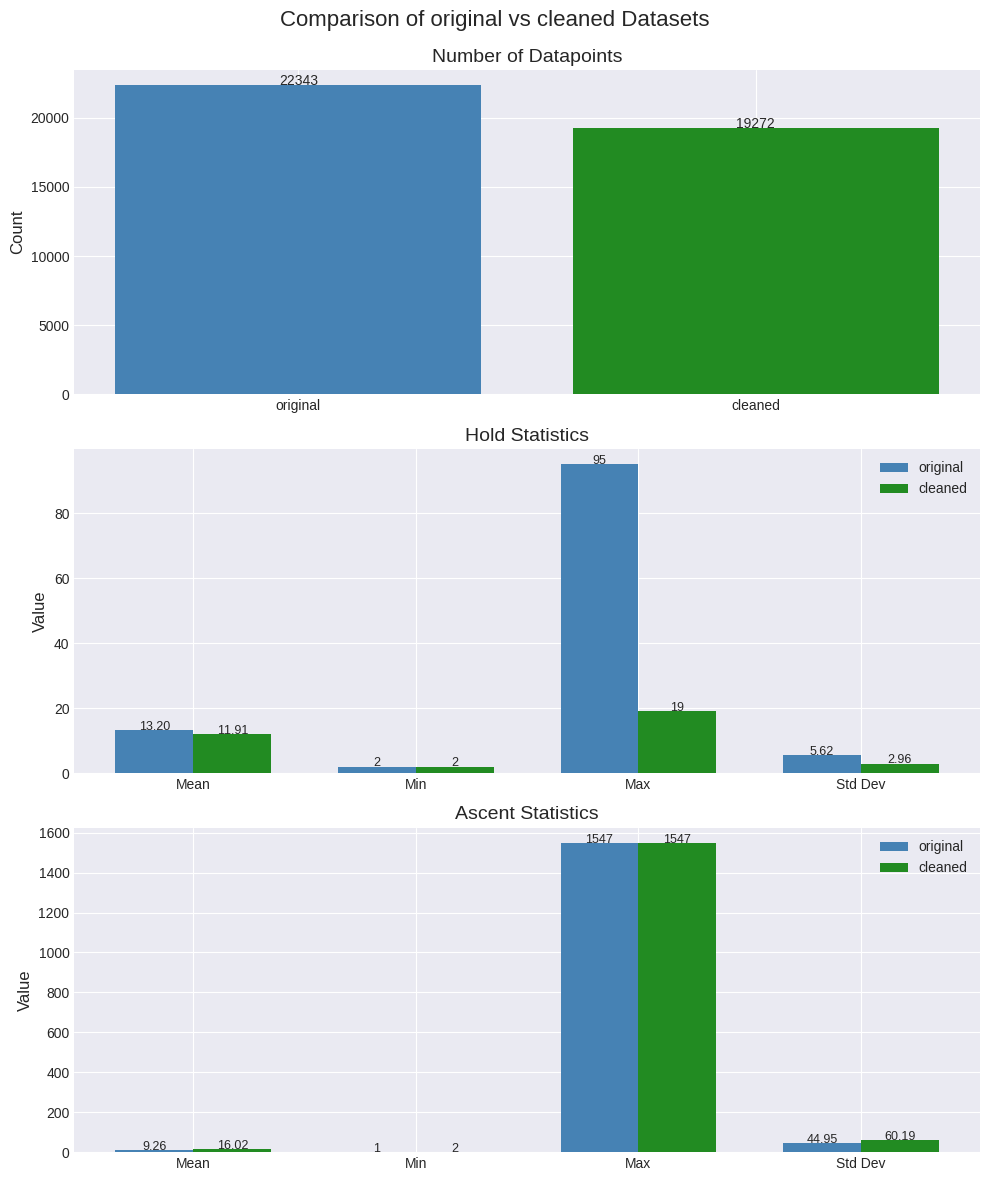

In [25]:
comp = compare_climbing_dataframes(climbs, cleaned_climbs, df1_name="original", df2_name="cleaned")

In [ ]:
cleaned_climbs = pd.read_csv('/content/drive/MyDrive/kilterboard_data/cleaned_climbs.csv')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_grade_distribution(data, output_file=None, most_popular_only=True,
                            title=None, figsize=(12, 6)):
    """
    Create a sorted grade distribution plot from Kilterboard data.

    Parameters:
    -----------
    data : pandas.DataFrame or dict
        Either a DataFrame with climb data or the output from create_data_profile()
    output_file : str, optional
        Path to save the plot (if None, plot will be displayed)
    most_popular_only : bool, optional
        Whether to count only the most popular angle for each climb (default: True)
    title : str, optional
        Custom title for the plot (if None, a default title will be used)
    figsize : tuple, optional
        Figure size as (width, height)

    Returns:
    --------
    dict
        Dictionary with grade distribution data
    """
    # Define grade order for sorting
    grade_order = ['VB', 'V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
                  'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16+']

    # Check if data is already processed
    if isinstance(data, dict) and ('popular_grades_count' in data or 'all_grades_count' in data):
        # Use pre-calculated data
        if most_popular_only and 'popular_grades_count' in data:
            grades_count = data['popular_grades_count']
        elif 'all_grades_count' in data:
            grades_count = data['all_grades_count']
        else:
            print("Warning: Using available grade count data")
            grades_count = data.get('popular_grades_count', data.get('all_grades_count', {}))
    else:
        # We need to process the DataFrame
        if not isinstance(data, pd.DataFrame):
            print("Error: Input must be either a DataFrame or output from create_data_profile()")
            return None

        # Process data to get grade counts

        if most_popular_only:
            # Count each boulder only once at its most popular angle
            grades = []
            for _, row in data.iterrows():
                popular_setup = find_most_popular_setup(row.get('climb_stats', []))
                if popular_setup:
                    difficulty = popular_setup.get('difficulty_average')
                    if difficulty is not None:
                        vgrade = difficulty_to_vgrade(difficulty)
                        grades.append(vgrade)
        else:
            # Count all setups at all angles
            grades = []
            for _, row in data.iterrows():
                stats_list = parse_climb_stats(row.get('climb_stats', []))
                for stats in stats_list:
                    difficulty = stats.get('difficulty_average')
                    if difficulty is not None:
                        vgrade = difficulty_to_vgrade(difficulty)
                        grades.append(vgrade)

        # Create the counter dictionary
        grades_count = Counter(grades)

    # Filter out any 'N/A' grades
    if 'N/A' in grades_count:
        del grades_count['N/A']

    # Create sorted list of grades and counts
    sorted_grades = []
    sorted_counts = []

    # Sort according to grade_order
    for grade in grade_order:
        if grade in grades_count:
            sorted_grades.append(grade)
            sorted_counts.append(grades_count[grade])

    # Create the plot
    plt.figure(figsize=figsize)

    # Create bars with a nice color gradient from light to dark
    bar_colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(sorted_grades)))

    # Plot bars
    bars = plt.bar(sorted_grades, sorted_counts, color=bar_colors)

    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{int(height)}',
                 ha='center', va='bottom', rotation=0, fontsize=9)

    # Set title
    if title is None:
        if most_popular_only:
            title = 'Distribution of Boulder Problems by V-Grade (Most Popular Angle)'
        else:
            title = 'Distribution of Boulder Problems by V-Grade (All Angles)'

    plt.xlabel('V-Grade', fontsize=12)
    plt.ylabel('Number of Problems', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    # Save or show
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Grade distribution plot saved to {output_file}")
    else:
        plt.show()

    plt.close()

    # Return the data
    return {
        'sorted_grades': sorted_grades,
        'sorted_counts': sorted_counts,
        'grades_count': dict(grades_count)
    }

# Example usage
#if __name__ == "__main__":
    # This function requires helper functions: difficulty_to_vgrade, parse_climb_stats, find_most_popular_setup
    # which should be defined in your main code

    # With a DataFrame
    #plot_grade_distribution(cleaned_climbs, output_file='/content/drive/MyDrive/kilterboard_data/sorted_grade_distribution.png')

    # With profile data
    # plot_grade_distribution(profile, output_file='/content/drive/MyDrive/kilterboard_data/sorted_grade_distribution.png')

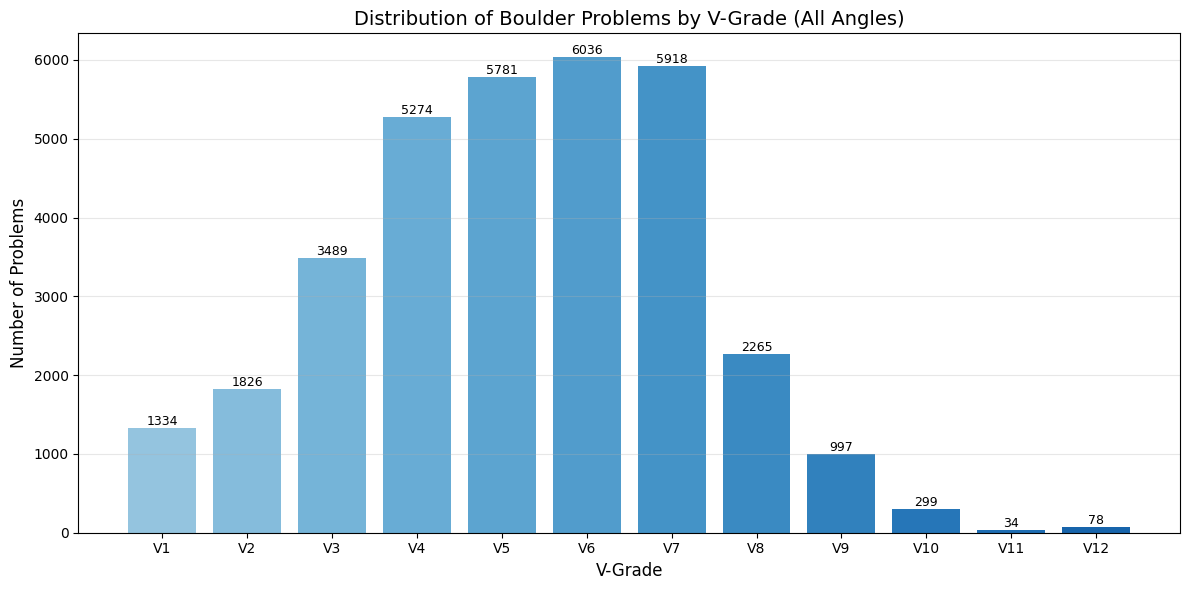

{'sorted_grades': ['V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6',
  'V7',
  'V8',
  'V9',
  'V10',
  'V11',
  'V12'],
 'sorted_counts': [1334,
  1826,
  3489,
  5274,
  5781,
  6036,
  5918,
  2265,
  997,
  299,
  34,
  78],
 'grades_count': {'V3': 3489,
  'V2': 1826,
  'V4': 5274,
  'V5': 5781,
  'V6': 6036,
  'V7': 5918,
  'V1': 1334,
  'V8': 2265,
  'V12': 78,
  'V9': 997,
  'V10': 299,
  'V11': 34}}

In [ ]:
plot_grade_distribution(cleaned_climbs, most_popular_only=False)

In [ ]:
new_profile = create_data_profile(cleaned_climbs)

Dataset contains 20211 boulder problems

1. Boulder Count Per Grade (All Angles):
  V1: 1334 problems
  V2: 1826 problems
  V3: 3489 problems
  V4: 5274 problems
  V5: 5781 problems
  V6: 6036 problems
  V7: 5918 problems
  V8: 2265 problems
  V9: 997 problems
  V10: 299 problems
  V11: 34 problems
  V12: 78 problems

2. Boulder Count Per Grade (Most Popular Angle Only):
  V1: 683 problems
  V2: 898 problems
  V3: 1862 problems
  V4: 3073 problems
  V5: 3621 problems
  V6: 3813 problems
  V7: 3829 problems
  V8: 1466 problems
  V9: 679 problems
  V10: 192 problems
  V11: 25 problems
  V12: 70 problems

3. Average Number of Holds Used: 11.78

Hold Count Distribution:
  (0, 5]: 204 problems
  (5, 10]: 7122 problems
  (10, 15]: 10338 problems
  (15, 20]: 2547 problems
  (20, 25]: 0 problems
  (25, 30]: 0 problems
  (30, 35]: 0 problems
  (35, 40]: 0 problems
  (40, 45]: 0 problems
  (45, 50]: 0 problems

4. Board Angle Distribution:
  0°: 331 setups
  5°: 324 setups
  10°: 771 setups
  15

In [ ]:
def create_boulder_angle_dataframe(original_df, min_ascents=2):
    """
    Create a new DataFrame with separate entries for each boulder at each angle,
    filtering out entries with fewer than the specified minimum ascents.

    Parameters:
    -----------
    original_df : pandas.DataFrame
        The original DataFrame containing the boulder data with 'climb_stats' column
    min_ascents : int, optional
        Minimum number of ascents required to include an entry (default: 3)

    Returns:
    --------
    pandas.DataFrame
        A new DataFrame with columns ['name', 'angle', 'grade', 'placements', 'ascents', 'hold_count']
        where 'grade' is the 'difficulty_average' from 'climb_stats'
    """
    # Create an empty list to store the new rows
    new_rows = []

    # Iterate through each row in the original DataFrame
    for _, row in original_df.iterrows():
        name = row['name']
        placements = row['placements']
        hold_count = row['hold_count'] if 'hold_count' in row else count_holds(placements)

        # Use the existing parse_climb_stats function to get the stats data
        stats_list = parse_climb_stats(row['climb_stats'])

        # Process each angle's stats
        for stats in stats_list:
            # Extract the required fields
            angle = stats.get('angle')
            grade = stats.get('difficulty_average')
            ascents = stats.get('ascensionist_count', 0)  # Using your naming convention from helper functions

            # Skip entries with missing critical data or insufficient ascents
            if angle is None or grade is None:
                continue

            # Filter out entries with fewer than min_ascents
            if ascents < min_ascents:
                continue

            # Create a new row
            new_row = {
                'name': name,
                'angle': int(angle),  # Ensure angle is an integer
                'grade': grade,
                'placements': placements,
                'ascents': ascents,
                'hold_count': hold_count
            }

            new_rows.append(new_row)

    # Create the new DataFrame
    new_df = pd.DataFrame(new_rows)

    # Print statistics about filtering
    total_entries = sum(len(parse_climb_stats(row['climb_stats'])) for _, row in original_df.iterrows())
    filtered_entries = len(new_df)
    removed_entries = total_entries - filtered_entries

    print(f"Total angle-specific entries: {total_entries}")
    print(f"Entries with {min_ascents}+ ascents: {filtered_entries}")
    print(f"Removed entries: {removed_entries} ({removed_entries/total_entries*100:.1f}% of total)")

    return new_df

In [ ]:
new_df = create_boulder_angle_dataframe(cleaned_climbs)

Total angle-specific entries: 33331
Entries with 2+ ascents: 19272
Removed entries: 14059 (42.2% of total)
